In [1]:
#! pip install spacy
#! python3 -m spacy download en_core_web_sm
#! pip install pyLDAvis
#! pip install --upgrade gensim
#! pip install --upgrade pandas
#! pip install --upgrade numpy

In [40]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [41]:
import pandas as pd
import requests
import json
import spacy
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [42]:
# Load an English pipeline for spacy
nlp = spacy.load("en_core_web_sm")

## Utility Functions

In [79]:
def get_reddit_posts(subreddit, type_of_posts, limit, timeframe):
    """
    Call the Reddit API passing the subreddit title,
    type of posts, limit and time window to fetch
    """
    try:
        base_url = f'https://www.reddit.com/r/{subreddit}/{type_of_posts}.json?limit={limit}&t={timeframe}'
        request = requests.get(base_url,
                               headers = {'User-agent': 'DataAnalytics'})
    except:
        print('An error occured during the call to Reddit endpoint.')

    return request.json()

def convert_from_json_to_dataframe(reddit_posts_json):
    """
    Create a DataFrame with title, URL, number of comments
    """
    reddit_posts_dict = {}
    for i, post in enumerate(reddit_posts_json['data']['children']):
        reddit_posts_dict[i] = {'title':post['data']['title'],
                                'url':post['data']['url'],
                                'comments':post['data']['num_comments']}

    df = pd.DataFrame.from_dict(reddit_posts_dict, orient='index')

    return df

def split_lda_result(topics):
  """
  Given the result of LDA model (topics), creates
  a list of topics where a topic is a list of tuples,
  a tuple is composed by (probability, word)
  """
  result = list()

  for (i, value) in topics:
    splitted_topics = value.split('+')
    tmp_list = list()
    for prob_word in splitted_topics:
      splitted_prob_word = prob_word.split('*')

      probability = float(splitted_prob_word[0].strip())
      word = str(splitted_prob_word[1].strip().replace('"',''))

      tmp_list.append( (probability, word) )

    result.append(tmp_list)

  return result

def get_common_words_between_topics(topic_one, topic_two, threshold):
  """
  Get a set of common words between two topics based on a probability threshold
  """
  words_in_topic_one = set([word for prob, word in topic_one if prob >= threshold])
  words_in_topic_two = set([word for prob, word in topic_two if prob >= threshold])

  result = words_in_topic_one.intersection(words_in_topic_two)

  return result

## Define arguments for calling Reddit API

In [80]:
# Call the "top" last month's 100 posts within the "datascience" subreddit
subreddit = 'datascience'
type_of_posts = 'top'         # controversial, best, hot, new, random, rising, top
limit = 100
timeframe = 'month'           #hour, day, week, month, year, all

In [81]:
# Get reddit titles of posts from its API calling utility function "get_reddit_posts"
reddit_posts_json = get_reddit_posts(subreddit, type_of_posts, limit, timeframe)

In [82]:
# Convert reddit posts from json to dataframe calling utility function "convert_from_json_to_dataframe"
df = convert_from_json_to_dataframe(reddit_posts_json)

In [83]:
# Overview of the dataframe content
df

,title,url,comments
0,What opinion about data science would you defe...,https://i.redd.it/20r6sbok4a4c1.jpg,629
1,A gentle reminder that the market is a shitsho...,https://www.reddit.com/r/datascience/comments/...,179
2,125k offer as a data scientist but I have no i...,https://www.reddit.com/r/datascience/comments/...,277
3,6 months as a Data Science freelancer,https://www.reddit.com/r/datascience/comments/...,117
4,Every AI startup right now,https://i.redd.it/t08yextu6x2c1.png,28
...,...,...,...
95,"Job advice, dealing with higher ups",https://www.reddit.com/r/datascience/comments/...,30
96,"Handed a dataset, what’s your sniff test?",https://www.reddit.com/r/datascience/comments/...,24
97,MS Statistics vs. MS CS,https://www.reddit.com/r/datascience/comments/...,37
98,Companies with good work-life balance reputati...,https://www.reddit.com/r/datascience/comments/...,26


## Pre-Processing

In this phase we need to prepare a corpus for the Latent Dirichlet Allocation model:

  

1.   Tokenize the text (titles of posts within df['title'])
2.   Create a dictionary
3.   Create a corpus of bag of words (BoW)



In [48]:
# Tokenize and preprocess the titles of Reddit posts using Spacy
tokenized_docs = []

# Append to the list 'tokenized_docs' only if the token is not a stop word (not is_stop) and consist of alphabetic characters (is_alpha)
for doc in nlp.pipe(df['title']):
    tokenized_docs.append( [token.lemma_.lower() for token in doc if (token.is_alpha) and (not token.is_stop) ] )

In [49]:
# Create a Gensim dictionary and corpus
dictionary = corpora.Dictionary(tokenized_docs)

# Filter out words that appear in less than 2 documents or more than 80% of the documents
dictionary.filter_extremes(no_below=2, no_above=0.8)

In [50]:
# Create the corpus for LDA model, from doc to bag of words (bow)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

## Latent Dirichlet Allocation (LDA)

In [51]:
# Define the number of topics (k) to discover and the number of iteration
n_topics = 5
n_iteration = 30

In [52]:
# Build the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=n_iteration, alpha='auto', eta='auto')

In [53]:
# Print the topics
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.145*"data" + 0.130*"science" + 0.090*"good" + 0.068*"datum" + 0.046*"industry"
Topic 1: 0.121*"ds" + 0.117*"work" + 0.050*"year" + 0.038*"model" + 0.038*"life"
Topic 2: 0.055*"job" + 0.055*"datum" + 0.042*"cs" + 0.042*"ms" + 0.042*"role"
Topic 3: 0.097*"scientist" + 0.084*"data" + 0.057*"advice" + 0.048*"work" + 0.043*"need"
Topic 4: 0.057*"think" + 0.057*"recruiter" + 0.057*"like" + 0.039*"etc" + 0.039*"build"


In [54]:
# Visualize the topics using pyLDAvis
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary, n_jobs=1)

In [55]:
pyLDAvis.display(lda_vis)

## Common words between topics

In [60]:
# Get lda_model topics (each one containing five words)
topics = lda_model.print_topics(num_words=5)
topics

[(0,
  '0.145*"data" + 0.130*"science" + 0.090*"good" + 0.068*"datum" + 0.046*"industry"'),
 (1,
  '0.121*"ds" + 0.117*"work" + 0.050*"year" + 0.038*"model" + 0.038*"life"'),
 (2, '0.055*"job" + 0.055*"datum" + 0.042*"cs" + 0.042*"ms" + 0.042*"role"'),
 (3,
  '0.097*"scientist" + 0.084*"data" + 0.057*"advice" + 0.048*"work" + 0.043*"need"'),
 (4,
  '0.057*"think" + 0.057*"recruiter" + 0.057*"like" + 0.039*"etc" + 0.039*"build"')]

In [61]:
# Call utility function "split_lda_result" to separate the probability and word
result = split_lda_result(topics)
result

[[(0.145, 'data'),
  (0.13, 'science'),
  (0.09, 'good'),
  (0.068, 'datum'),
  (0.046, 'industry')],
 [(0.121, 'ds'),
  (0.117, 'work'),
  (0.05, 'year'),
  (0.038, 'model'),
  (0.038, 'life')],
 [(0.055, 'job'),
  (0.055, 'datum'),
  (0.042, 'cs'),
  (0.042, 'ms'),
  (0.042, 'role')],
 [(0.097, 'scientist'),
  (0.084, 'data'),
  (0.057, 'advice'),
  (0.048, 'work'),
  (0.043, 'need')],
 [(0.057, 'think'),
  (0.057, 'recruiter'),
  (0.057, 'like'),
  (0.039, 'etc'),
  (0.039, 'build')]]

In [58]:
# Define a threshold to filter out words with probability < threshold
threshold = 0.04

for i in range(len(result)):
  j = i + 1
  while j < len(result):
      # Call utility function "get_common_words_between_topics" passing topic_x and topic_y
      # Get common words between two topics
      common_words = get_common_words_between_topics(result[i], result[j], threshold) # result[i] = topic_x, result[j] = topic_y

      if len(common_words) > 0:
        for common_word in common_words:
          print(f'Common word between topic-{i} and topic-{j}: {common_word}')

      j = j + 1

Common word between topic-0 and topic-2: datum
Common word between topic-0 and topic-3: data
Common word between topic-1 and topic-3: work


## WordCloud

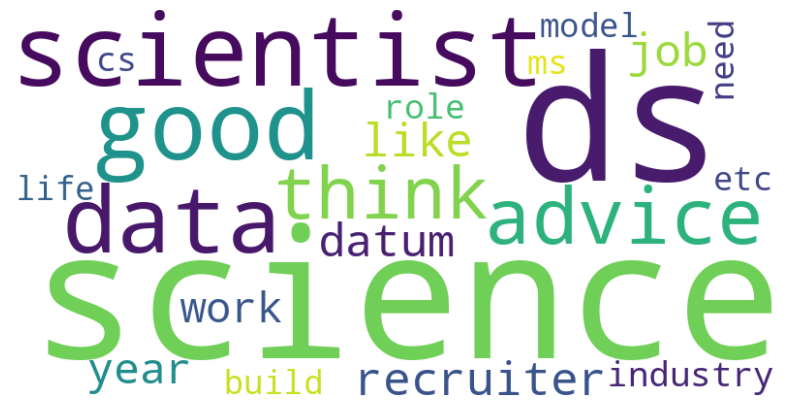

In [59]:
# Concatenate all words and probabilities into a single dictionary
wordcloud_dict = {word: probability for topic in result for probability, word in topic}

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## References

spaCy: https://spacy.io/api/token

Gensim and LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

WordCloud: https://amueller.github.io/word_cloud/